# Creating Model for Skin Disease Classification using CNN

## 1. Preparation

Importing necessary library

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

Defining path

In [2]:
train_dir = r'C:\Users\mgusn\OneDrive\Documents\alay sat\Bangkit\ML\faceskindisease\DATA\train'
test_dir = r'C:\Users\mgusn\OneDrive\Documents\alay sat\Bangkit\ML\faceskindisease\DATA\testing'

Inspecting Directory Structure

In [3]:
import os

def list_directory_contents(directory, max_files_per_level=5):
    for root, dirs, files in os.walk(directory):
        level = root.replace(directory, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 4 * (level + 1)
        file_count = 0
        for f in files:
            if file_count < max_files_per_level:
                print(f'{subindent}{f}')
                file_count += 1
            else:
                print(f'{subindent}...')
                break


print("Training Directory Structure:")
list_directory_contents(train_dir)

print("\nTest Directory Structure:")
list_directory_contents(test_dir)


Training Directory Structure:
train/
    Acne/
        033007HB.jpg
        033073HB.jpg
        07AcnePittedScars.jpg
        acne-closed-comedo-003.jpg
        acne-closed-comedo-1.jpg
        ...
    Actinic Keratosis/
        actinic-keratosis-5FU-1.jpg
        actinic-keratosis-5FU-11.jpg
        actinic-keratosis-5FU-12.jpg
        actinic-keratosis-5FU-14.jpg
        actinic-keratosis-5FU-16.jpg
        ...
    Basal Cell Carcinoma/
        basal-cell-carcinoma-face-1.jpg
        basal-cell-carcinoma-face-14.jpg
        basal-cell-carcinoma-face-15.jpg
        basal-cell-carcinoma-face-16.jpg
        basal-cell-carcinoma-face-18.jpg
        ...
    Eczemaa/
        03Eczema0915.jpg
        040106HB.jpg
        040116HB.jpg
        042810HB.jpg
        042869HB.jpg
        ...
    Rosacea/
        07rosacea010206OK.jpg
        07RosaceaForehead.jpg
        07RosaceaFulFAce.jpg
        07RosaceaK0216.jpg
        07RosaceaK02161.jpg
        ...

Test Directory Structure:
testing/
 

## 2. Augmenting Dataset

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,            
    width_shift_range=0.3,        
    height_shift_range=0.3,       
    shear_range=0.3,              
    zoom_range=0.3,               
    horizontal_flip=True,
    vertical_flip=True,           
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],  
    channel_shift_range=0.2,            
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=64,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=64,
    class_mode='categorical'
)

Found 440 images belonging to 5 classes.
Found 185 images belonging to 5 classes.


## 3. Creating Model Architecture

Load Pre-trained model

In [5]:
# Load pre-trained DenseNet model
base_model = MobileNet(weights='imagenet', 
                         include_top=False, 
                         input_shape=(150, 150, 3))

base_model.summary()



Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 75, 75, 32)        864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 75, 75, 32)        128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 75, 75, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 75, 75, 32)        288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 75, 75, 32

In [6]:
len(base_model.layers)

86

Add Fine Tuning

In [7]:
fine_tuning_at = 50

In [8]:
# Freeze pre-trained layers
for layer in base_model.layers[:fine_tuning_at]:
    layer.trainable = False

Creating the Model

In [9]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='softmax', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

Learning Rate Adjustment

In [10]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

Monitoring Loss

In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

Compile the Model

In [12]:
model.compile(optimizer='RMSprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

Creating Callback

In [13]:
class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_acc_threshold=0.90, train_acc_threshold=0.90):
        super(MyThresholdCallback, self).__init__()
        self.val_acc_threshold = val_acc_threshold
        self.train_acc_threshold = train_acc_threshold

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get('val_accuracy')
        train_acc = logs.get('accuracy')
        if val_acc is not None and train_acc is not None:
            if val_acc >= self.val_acc_threshold and train_acc >= self.train_acc_threshold:
                print(f"\nReached {self.val_acc_threshold*100}% validation accuracy and {self.train_acc_threshold*100}% train accuracy, stopping training!")
                self.model.stop_training = True

# Create an instance of the modified callback
my_callback = MyThresholdCallback(val_acc_threshold=0.90, train_acc_threshold=0.90)


Training the Model

In [14]:
history = model.fit(
    train_generator,   
    validation_data=test_generator,
    epochs=100,
    callbacks=[my_callback, reduce_lr, early_stopping]
)

Epoch 1/100


7/7 [==============================] - 11s 1s/step - loss: 1.8483 - accuracy: 0.3818 - val_loss: 1.9907 - val_accuracy: 0.2919 - lr: 0.0010
Epoch 2/100
7/7 [==============================] - 7s 1s/step - loss: 1.6288 - accuracy: 0.5705 - val_loss: 1.9716 - val_accuracy: 0.3189 - lr: 0.0010
Epoch 3/100
7/7 [==============================] - 7s 1s/step - loss: 1.4651 - accuracy: 0.6364 - val_loss: 1.9487 - val_accuracy: 0.3243 - lr: 0.0010
Epoch 4/100
7/7 [==============================] - 7s 1s/step - loss: 1.3675 - accuracy: 0.6705 - val_loss: 1.9388 - val_accuracy: 0.3027 - lr: 0.0010
Epoch 5/100
7/7 [==============================] - 7s 1s/step - loss: 1.2181 - accuracy: 0.7114 - val_loss: 1.9166 - val_accuracy: 0.2973 - lr: 0.0010
Epoch 6/100
7/7 [==============================] - 7s 1s/step - loss: 1.1673 - accuracy: 0.7386 - val_loss: 1.9084 - val_accuracy: 0.4541 - lr: 0.0010
Epoch 7/100
7/7 [==============================] - 7s 1s/step - loss: 1.1368 - accuracy: 0.

## 4. Evaluating Model

Validation and Training Comparison

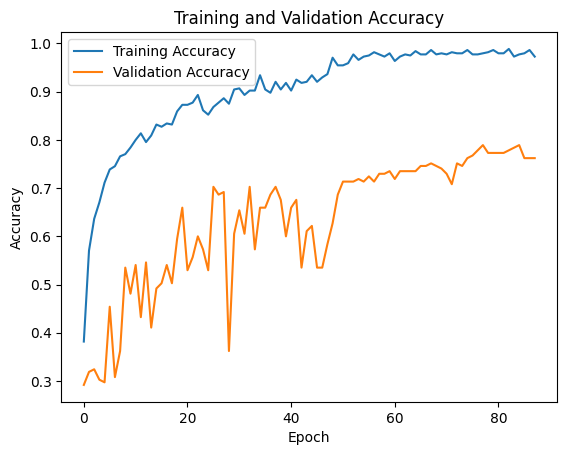

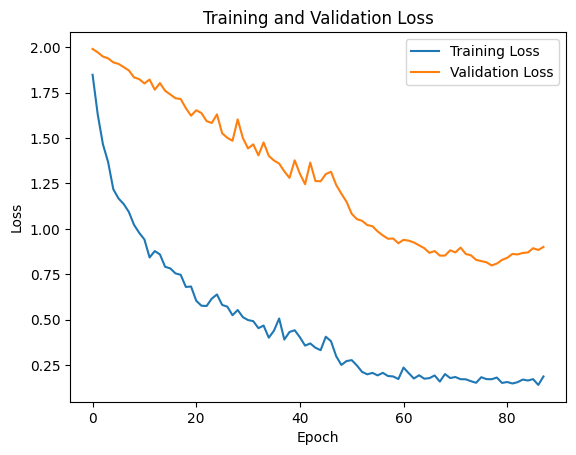

In [15]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Try to predict with the model

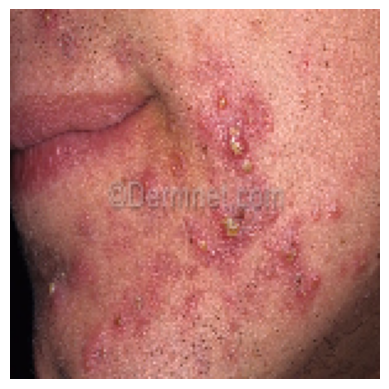

1/1 [==============================] - 0s 50ms/step
True label: Acne
Predicted label: Acne


In [25]:
# Get an image from the validation dataset
img_batch, true_labels_batch = next(test_generator)
img = img_batch[0]
true_label_index = np.argmax(true_labels_batch[0])

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

# Make prediction
prediction_scores = model.predict(np.expand_dims(img, axis=0))
predicted_label_index = np.argmax(prediction_scores)

# Get the class indices to class names mapping
class_indices = {v: k for k, v in test_generator.class_indices.items()}

# Get the true and predicted class labels
true_label = class_indices[true_label_index]
predicted_label = class_indices[predicted_label_index]

print("True label: " + true_label)
print("Predicted label: " + predicted_label)


## 5. Save Model

Save model as HDF5 (.h5)

In [17]:
model.save("skin_disease_classifier.h5")

c:\Users\mgusn\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Convert model to JSON and save

In [18]:
# Save the model architecture to a JSON file
model_json = model.to_json()
with open(r'C:\Users\mgusn\OneDrive\Documents\alay sat\Bangkit\ML\skin_disease_classifier.json', 'w') as json_file:
    json_file.write(model_json)

Save model as TFlite

In [19]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open("skin_disease_classifier.tflite", "wb") as tflite_file:
    tflite_file.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\mgusn\AppData\Local\Temp\tmpzbwcr21m\assets


INFO:tensorflow:Assets written to: C:\Users\mgusn\AppData\Local\Temp\tmpzbwcr21m\assets
